# Experimental validations

The pipeline of Mini-AutoML needs to be run prior to this notebook, in order to obtain predictions across the Enamine stock compounds. That pipeline will genereate, in an `assets` folder, the following files:

- `cross_validation_results.csv`
- `enamine_stock_predictions_enamine_stock.csv`

In addition, we use the `validation.tsv` file, containing experimental results from December 2022.

The current notebook also expects that the `InteractomeSignatures.ipynb` notebook has been run previously.

In [1]:
import pandas as pd
import csv
import os
import json
import shutil
import numpy as np
import joblib
import collections
import h5py
import blitzgsea as blitz
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from scipy.stats import fisher_exact
import stylia
from stylia.colors import ContinuousColorMap
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

with open("../results/topwiz_maxpxf100_minp4_maxp40/metadata.json", "r") as f:
    metadata = json.load(f)
    
MAX_PROTEIN_COUNTS = metadata["MAX_PROTEIN_COUNTS"]
MIN_PROTEIN_COUNTS = metadata["MIN_PROTEIN_COUNTS"]
MAX_PROTEINS_PER_FRAGMENTS = metadata["MAX_PROTEINS_PER_FRAGMENTS"]
MIN_PROTEINS_PER_FRAGMENTS = metadata["MIN_PROTEINS_PER_FRAGMENTS"]
TFIDF = metadata["TFIDF"]
    
cv = pd.read_csv("../results/topwiz_maxpxf100_minp4_maxp40/modeling_validations/validation_summary.csv")
dp = pd.read_csv("../results/topwiz_maxpxf100_minp4_maxp40/modeling_validations/enamine_predictions.csv")
#dp = pd.read_csv("../data/2303_EnamineStockPredictions_Predictions.csv")[list(dp.columns)]
tested = pd.read_csv("../data/2212_tested_enamine_compounds.csv")[["catalog_id", "fid", "original_validation"]]
dp = tested.merge(dp, on="catalog_id", how="right")
df = pd.read_csv("../data/validation.tsv", sep="\t")
df = df[df["Number_of_Protein_Unique_Peptides"] >= 2]
pid2name = {}
with open("../data/pid2name_primary_all.tsv", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    for r in reader:
        pid2name[r[0]] = r[1]

results_folder = "../results/topwiz_maxpxf100_minp4_maxp40"
output_folder = results_folder.replace("topwiz_", "validation_")

if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
os.mkdir(output_folder)

frag_ids = []
for fid in dp["fid"].tolist():
    if str(fid) == "nan":
        frag_ids += [np.nan]
    else:
        frag_id = fid.split("-")[1]
        if len(frag_id) == 5:
            frag_ids += [frag_id]
        else:
            if frag_id == "V059":
                frag_id = "V0081"
            elif frag_id == "V060":
                frag_id = "V0157"
            elif frag_id == "V062":
                frag_id = "V0302"
            elif frag_id == "V065":
                frag_id = "V0480"
            else:
                frag_id = frag_id.replace("V", "V0")
            frag_ids += [frag_id]
dp["FragID"] = frag_ids

tested_fids = sorted(set(df["FragID"]))

pht = pd.read_csv(os.path.join(results_folder, "ProteinHasTopic.csv"))
topic_names = list(pht.columns)[4:]
NUM_TOPICS = len(topic_names)

local_proteins = set(pht["gene_name"])

def tokenizer(x):
    return x.split(" ")

data_for_wizard = joblib.load(os.path.join(results_folder, "data_for_wizard.joblib"))

def get_X_from_esm():
    with h5py.File("../data/pid2seq_esm1b.h5", "r") as f:
        the_pids = [x.decode("utf-8") for x in f["Keys"][:]]
        X = f["Values"][:]
        the_pids_idxs = dict((k,i) for i,k in enumerate(the_pids))
    return X, the_pids, the_pids_idxs

def get_X_from_bioteque(metapath_name="gene_has_cmp"):
    with h5py.File("../data/bioteque/{0}/GEN_emb.h5".format(metapath_name), "r") as f:
        X = f["m"][:]
    with open("../data/bioteque/{0}/GEN_ids.txt".format(metapath_name), "r") as f:
        the_pids = []
        for l in f:
            the_pids += [l.rstrip()]
    the_pids_idxs = dict((k,i) for i,k in enumerate(the_pids))
    return X, the_pids, the_pids_idxs

def get_X_merged(n_components=300):
    X_1, the_pids_1, the_pids_idxs_1 = get_X_from_bioteque("gene_has_cmp")
    X_2, the_pids_2, the_pids_idxs_2 = get_X_from_esm()
    the_pids = sorted(set(the_pids_1).intersection(the_pids_2))
    R = []
    for pid in the_pids:
        r = [x for x in X_1[the_pids_idxs_1[pid]]] + [x for x in X_2[the_pids_idxs_2[pid]]]
        R += [r]
    X = np.array(R)
    X = PCA(n_components=n_components).fit_transform(X)
    the_pids_idxs = dict((k,i) for i,k in enumerate(the_pids))
    return X, the_pids, the_pids_idxs

X_emb, emb_pids, emb_pids_idxs = get_X_merged()

db = pd.read_csv("../data/cemm_primary_hit_data.tsv", sep="\t")

fids = sorted(set(df["FragID"]))
fid2smi = pd.read_csv("../data/fid2can_fff_all.tsv", sep="\t")
fid2smi = fid2smi[fid2smi["fid"].isin(fids)].sort_values("fid")
fid2smi_dict = {}
for r in fid2smi.values:
    fid2smi_dict[r[0]] = r[1]

pid2name = {}
with open("../data/pid2name_primary_all.tsv", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    for r in reader:
        pid2name[r[0]] = r[1]

protein_counts = collections.defaultdict(int)
for r in db["UniProtID"].tolist():
    protein_counts[r] += 1
protein_counts = sorted(protein_counts.items(), key=lambda x: -x[1])

fragment_counts = collections.defaultdict(int)
for r in db["FragID"].tolist():
    fragment_counts[r] += 1
fragment_counts = sorted(fragment_counts.items(), key=lambda x: -x[1])

protein_counts = collections.defaultdict(int)
for r in db["UniProtID"].tolist():
    protein_counts[r] += 1

max_counts = MAX_PROTEIN_COUNTS
pids = sorted(set(db["UniProtID"]))
pids = [x for x in pids if protein_counts[x] <= max_counts]
min_counts = MIN_PROTEIN_COUNTS
pids = [x for x in pids if protein_counts[x] >= min_counts]
pids = sorted(set(pids).intersection(emb_pids))

emb_idxs = []
for pid in pids:
    emb_idxs += [emb_pids_idxs[pid]]
X_emb = X_emb[emb_idxs]

pid2idx = dict((k,i) for i,k in enumerate(pids))
pids_set = set(pids)

fids = sorted(set(df["FragID"]))
fid2idx = dict((k,i) for i,k in enumerate(fids))

Y_pro = np.full((len(fids), len(pids)), np.nan)

cols = [
    "FragID",
    "Accession",
    "Number_of_Protein_Unique_Peptides",
    "Rank_relative",
    "Abundance_Ratio_log2",
    "Abundance_Ratio_log2_median_corr",
    "Abundance_Ratio_PValue",
    "Abundance_Ratio_Adj_PValue"
]

for r in df[cols].values:
    if r[1] not in pids_set:
        continue
    i = fid2idx[r[0]]
    j = pid2idx[r[1]]
    unique_peptides = float(r[2])
    rank_relative = float(r[3])
    log2fc = float(r[4])
    log2fc_median = float(r[5])
    p_value = float(r[6])
    p_value_adj = float(r[7])
    if unique_peptides < 2:
        continue
    if np.isnan(p_value):
        continue
    if np.isnan(log2fc):
        continue
    Y_pro[i,j] = log2fc

R_pro = np.array(Y_pro)
R_pro[np.isnan(R_pro)] = -999

def read_annotations(annotations_file):
    d = collections.defaultdict(list)
    with open(annotations_file, "r") as f:
        reader = csv.reader(f, delimiter="\t")
        for r in reader:
            if r[0] not in pid2name:
                continue
            d[r[1]] += [pid2name[r[0]]]
    d = dict((k, set(v)) for k,v in d.items() if len(v) >= 5)
    return d

cc_annotations = read_annotations("../data/msigdb_gocc.tsv")
mf_annotations = read_annotations("../data/msigdb_gomf.tsv")

/Users/mduranfrigola/miniconda3/envs/topicmodel/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/mduranfrigola/miniconda3/envs/topicmodel/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator NMF from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/mduranfrigola/miniconda3/envs/topicmodel/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 1.2.1 when using v

In [10]:
gsea_prefiltering_file = os.path.join(output_folder, "gsea_prefiltering_minp{0}_maxp{1}.joblib".format(MIN_PROTEIN_COUNTS, MAX_PROTEIN_COUNTS))

if os.path.exists(gsea_prefiltering_file):
    print("It does exists")
    gsea_prefiltering_results = joblib.load(gsea_prefiltering_file)
else:
    print("It doesn't exist")
    gsea_prefiltering_results = []
    for i in range(R_pro.shape[0]):
        print(i, R_pro.shape[0])
        v = np.array(R_pro[i,:])
        mask = v != -999
        pids_ = [pids[i] for i in range(len(v)) if mask[i]]
        v_ = PowerTransformer().fit_transform(v[mask].reshape(-1,1))[:,0]
        genes_ = [pid2name[p] for p in pids_]
        signature = pd.DataFrame({0: genes_, 1: v_})
        cc_ = dict((k,list(v.intersection(genes_))) for k,v in cc_annotations.items())
        mf_ = dict((k,list(v.intersection(genes_))) for k,v in mf_annotations.items())
        cc_ = dict((k,v) for k,v in cc_.items() if len(v) >= 5)
        mf_ = dict((k,v) for k,v in mf_.items() if len(v) >= 5)
        result_cc = blitz.gsea(signature, cc_, anchors=4, permutations=2000, processes=4, signature_cache=True)
        result_mf = blitz.gsea(signature, mf_, anchors=4, permutations=2000, processes=4, signature_cache=True)
        gsea_prefiltering_results += [(fids[i], signature, result_cc, result_mf)]
    joblib.dump(gsea_prefiltering_results, gsea_prefiltering_file)

It doesn't exist
0 35


Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.40it/s]

1 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.41it/s]

2 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.41it/s]

3 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.41it/s]

4 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.32it/s]

5 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.39it/s]

6 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.42it/s]

7 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.69it/s]

8 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.74it/s]

9 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.75it/s]


10 35


Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.70it/s]

11 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.73it/s]

12 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.78it/s]

13 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.73it/s]

14 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.04it/s]

15 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.15it/s]

16 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.10it/s]

17 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.11it/s]

18 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.15it/s]

19 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.14it/s]

20 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.08it/s]

21 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.54it/s]

22 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.55it/s]

23 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.61it/s]

24 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.48it/s]

25 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.48it/s]

26 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.54it/s]

27 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.51it/s]

28 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.69it/s]

29 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.65it/s]

30 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.69it/s]

31 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.63it/s]

32 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.63it/s]

33 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.81it/s]

34 35



Calibration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.72it/s]


In [11]:
def do_documents_list(min_proteins_per_fragment):
    gsea_pval = 0.05
    documents_list = []
    cap = 250
    hits = []
    for fid in fids:
        pids_ = db[db["FragID"] == fid]["UniProtID"]
        pids_ = set(pids_).intersection(pids)
        genes_ = [pid2name[p] for p in pids_]
        hits += [set(genes_)]
    gid2idx = dict((pid2name[k],i) for i,k in enumerate(pids))
    for i in range(R_pro.shape[0]):
        gs = gsea_prefiltering_results[i]
        cc = gs[2]
        cc = cc[cc["pval"] < gsea_pval]
        mf = gs[3]
        mf = mf[mf["pval"] < gsea_pval]
        cc_genes = [g for x in cc["leading_edge"].tolist() for g in x.split(",")]
        mf_genes = [g for x in mf["leading_edge"].tolist() for g in x.split(",")]
        le = list(cc_genes + mf_genes)
        le = set([x for x in le if x != ""])
        v = R_pro[i,:]
        idxs = np.argsort(v)[::-1][:cap]
        pids_ = [pids[i] for i in idxs]
        genes_base = [pid2name[p] for p in pids_]
        genes_ = [g for g in genes_base if g in le]
        if len(genes_) > MAX_PROTEINS_PER_FRAGMENTS:
            genes_ = genes_[:MAX_PROTEINS_PER_FRAGMENTS]
        else:
            if len(genes_) < min_proteins_per_fragment:
                missing = min_proteins_per_fragment - len(genes_)
                ht = hits[i]
                exclusive_ht = ht.difference(le)
                if len(exclusive_ht) >= missing:
                    eh_list = list(exclusive_ht)
                    le_list = list(le)
                    eh_idxs = [gid2idx[k] for k in eh_list]
                    le_idxs = [gid2idx[k] for k in le_list]
                    nn = NearestNeighbors(n_neighbors=3)
                    nn.fit(X_emb[le_idxs])
                    I, D = nn.kneighbors(X_emb[eh_idxs])
                    dists = np.mean(D, axis=1)
                    idxs_ = np.argsort(dists)[:missing]
                    sel_eh = set([eh_list[idx] for idx in idxs_])
                    genes_ = [g for g in genes_base if g in le or g in sel_eh]
                else:
                    genes_ = [g for g in genes_base if g in le or g in ht]
                    missing = min_proteins_per_fragment - len(genes_)
                    eb_list = [g for g in genes_base if g not in genes_]
                    eb_idxs = [gid2idx[k] for k in eb_list]
                    le_list = list(le)
                    le_idxs = [gid2idx[k] for k in le_list]
                    nn = NearestNeighbors(n_neighbors=3)
                    nn.fit(X_emb[le_idxs])
                    I, D = nn.kneighbors(X_emb[eb_idxs])
                    dists = np.mean(D, axis=1)
                    idxs_ = np.argsort(dists)[:missing]
                    sel_eb = set([eb_list[idx] for idx in idxs_])
                    genes_ = [g for g in genes_base if g in le or g in ht or g in sel_eb]
            else:
                pass
        documents_list += [genes_]
    return documents_list

def create_documents():
    f0 = open("{0}/gene_docs.txt".format(output_folder), "w")
    f1 = open("{0}/fids.txt".format(output_folder), "w")
    for i, g in enumerate(documents_list):
        f0.write(" ".join(g) + "\n")
        f1.write(fids[i] + "\n")
    f0.close()
    f1.close()

documents_list = do_documents_list(MIN_PROTEINS_PER_FRAGMENTS)
create_documents()

def get_texts():
    with open("{0}/gene_docs.txt".format(output_folder), "r") as f:
        texts = [x.rstrip() for x in f.readlines()]
    return texts

texts = get_texts()

In [12]:
def get_texts_simple(top_n):
    idx2pid = dict((v,k) for k,v in pid2idx.items())
    texts = []
    for i in range(R_pro.shape[0]):
        idxs = np.argsort(R_pro[i,:])[::-1]
        idxs = idxs[:top_n]
        my_pids = [idx2pid[i] for i in idxs]
        my_gens = [pid2name[p] for p in my_pids]
        texts += [" ".join(my_gens)]
    return texts

texts_simple = get_texts_simple(25)

In [13]:
def get_prediction_score(topic_i, fid):
    r = dp[dp["FragID"]==fid]["signature_{0}".format(topic_i)]
    return float(r)

def calculate_enrichment(topic_i, fid, top_t, top_s, local):
    d = df[df["FragID"] == fid][["Accession", "Abundance_Ratio_log2"]]
    d = [(pid2name[x[0]], x[1]) for x in d.values if str(x[1]) != "nan"]
    d = sorted(d, key=lambda x: -x[1])
    if local:
        d = [x for x in d if x[0] in local_proteins]
    t = [tuple(x) for x in pht[["gene_name", "signature_{0}".format(topic_i)]].values]
    t = sorted(t, key=lambda x: -x[1])
    n = len(t)
    t = set([x[0] for x in t][:top_t]).intersection(local_proteins)
    d = set([x[0] for x in d][:top_s]).intersection(local_proteins)
    a = len(t.intersection(d))
    b = len(t)
    c = len(d)
    d = n - (a+b+c)
    M = [[a,b],[c,d]]
    odds, p_value = fisher_exact([[a,b],[c,d]], alternative="greater")
    results = {
        "m": M,
        "odds_ratio": odds,
        "p_value": p_value
    }
    return results

def calculate_topic_association(W, topic_i, fid):
    j = tested_fids.index(fid)
    return W[j, topic_i]
    

In [19]:
cmap = ContinuousColorMap()
cmap.fit([i for i in range(NUM_TOPICS)])
colors = cmap.transform([i for i in range(NUM_TOPICS)])

cmap = ContinuousColorMap()
cmap.fit([i for i in range(len(topic_names))])
topic_colors = cmap.transform([i for i in range(len(topic_names))])
topic_color_dict = dict((topic_names[i], c) for i,c in enumerate(topic_colors))

def roc_plot(ax, topic_i, sufix=40):
    x = np.arange(0,1.01,0.01)
    mdl_validation_metrics = joblib.load(os.path.join(results_folder, "modeling_validations", "validation_metrics.joblib".format(sufix)))
    idx = topic_i
    results = mdl_validation_metrics[idx]
    n_splits = results["n_splits"]
    ys = []
    for i in range(n_splits):
        fpr = results["fprs"][i]
        tpr = results["tprs"][i]
        ys += [np.interp(x, fpr, tpr)]
    ys = np.array(ys)
    y_mean = np.array([0] + list(np.mean(ys, axis=0)))
    y_std = np.array([0] + list(np.std(ys, axis=0)))
    x = np.array([0] + list(x))
    ax.plot(x, y_mean, zorder=1000, color=colors[idx], lw=1)
    ax.fill_between(x, y_mean+y_std, y_mean-y_std, color=topic_colors[idx], alpha=0.5, lw=0)
    ax.plot([0,1], [0,1], lw=0.5, color="lightgray")
    n = results["positives"]
    roc_mean = np.mean(results["aucs"])
    roc_std = np.std(results["aucs"])
    stylia.label(ax, title="N:{0} / {1:.3f} +/- {2:.3f}".format(n, roc_mean, roc_std), xlabel="FPR", ylabel="TPR")


def correlation_plots(W, sufix):
    corrs = []
    pvals = []
    max_scores = []
    for mt in range(NUM_TOPICS):
        my_topic = mt
        x = []
        y = []
        c = []
        scores = []
        for fid in tested_fids:
            for i in range(NUM_TOPICS):
                if i != my_topic:
                    continue
                s = get_prediction_score(i, fid)
                w = calculate_topic_association(W, i, fid)
                x += [s]
                y += [w]
                c += [i]
                scores += [s]
        r, p = pearsonr(x,y)
        corrs += [r]
        pvals += [p]
        max_scores += [np.max(scores)]
    dr = pd.DataFrame({"topic": range(NUM_TOPICS), "max_scores": max_scores, "corrs": corrs, "pvals": pvals})
    
    fig, axs = stylia.create_figure(3, NUM_TOPICS, width=20, height=8, height_ratios = [2.5,1,1])

    enr_results = pd.read_csv(os.path.join(results_folder, "enrichr_summary_results.csv"))
    
    R = []
    for i in range(NUM_TOPICS):
        ax = axs.next()
        x = [get_prediction_score(i, fid) for fid in tested_fids]
        y = [calculate_topic_association(W, i, fid) for fid in tested_fids]
        c = cmap.transform(x)
        sns.regplot(x=x, y=y, ax=ax, color=colors[i])
        rho, pval = pearsonr(x, y)
        title = "Signature {0}\nrho = {1:.2f} p = {2:.3f}\n\n".format(i, rho, pval)
        terms = enr_results[enr_results["topic"] == i]["term"].tolist()
        terms = [x[:40] for x in terms]
        for t in terms:
            title += t
            title += "\n"
        title.rstrip("\n")
        stylia.label(ax=ax, title=title, xlabel="Prediction score", ylabel="Association score")
        R += [(x,y)]

    for i in range(NUM_TOPICS):
        ax = axs.next()
        v = np.array(dp["signature_{0}".format(i)].tolist())
        ax.hist(v, bins=20, color=colors[i])
        a_9 = np.sum(v > 0.9)
        a_8 = np.sum(v > 0.8)
        a_7 = np.sum(v > 0.7)
        a_6 = np.sum(v > 0.6)
        title = "0.9: {0}, 0.8: {1}, 0.7: {2}, 0.6: {3}".format(a_9, a_8, a_7, a_6)
        stylia.label(ax=ax, title=title, ylabel="Counts", xlabel="Prediction score")
        x = [get_prediction_score(i, fid) for fid in tested_fids]
        ylim = ax.get_ylim()
        shift = (ylim[1]-ylim[0])*0.1
        ax.scatter(x, [-shift]*len(x), s=5, color=colors[i])
        
    for i in range(NUM_TOPICS):
        ax = axs.next()
        roc_plot(ax, i)

    plt.tight_layout()
    stylia.save_figure(os.path.join(output_folder, "validation_{0}.png".format(sufix)))
    
    return R

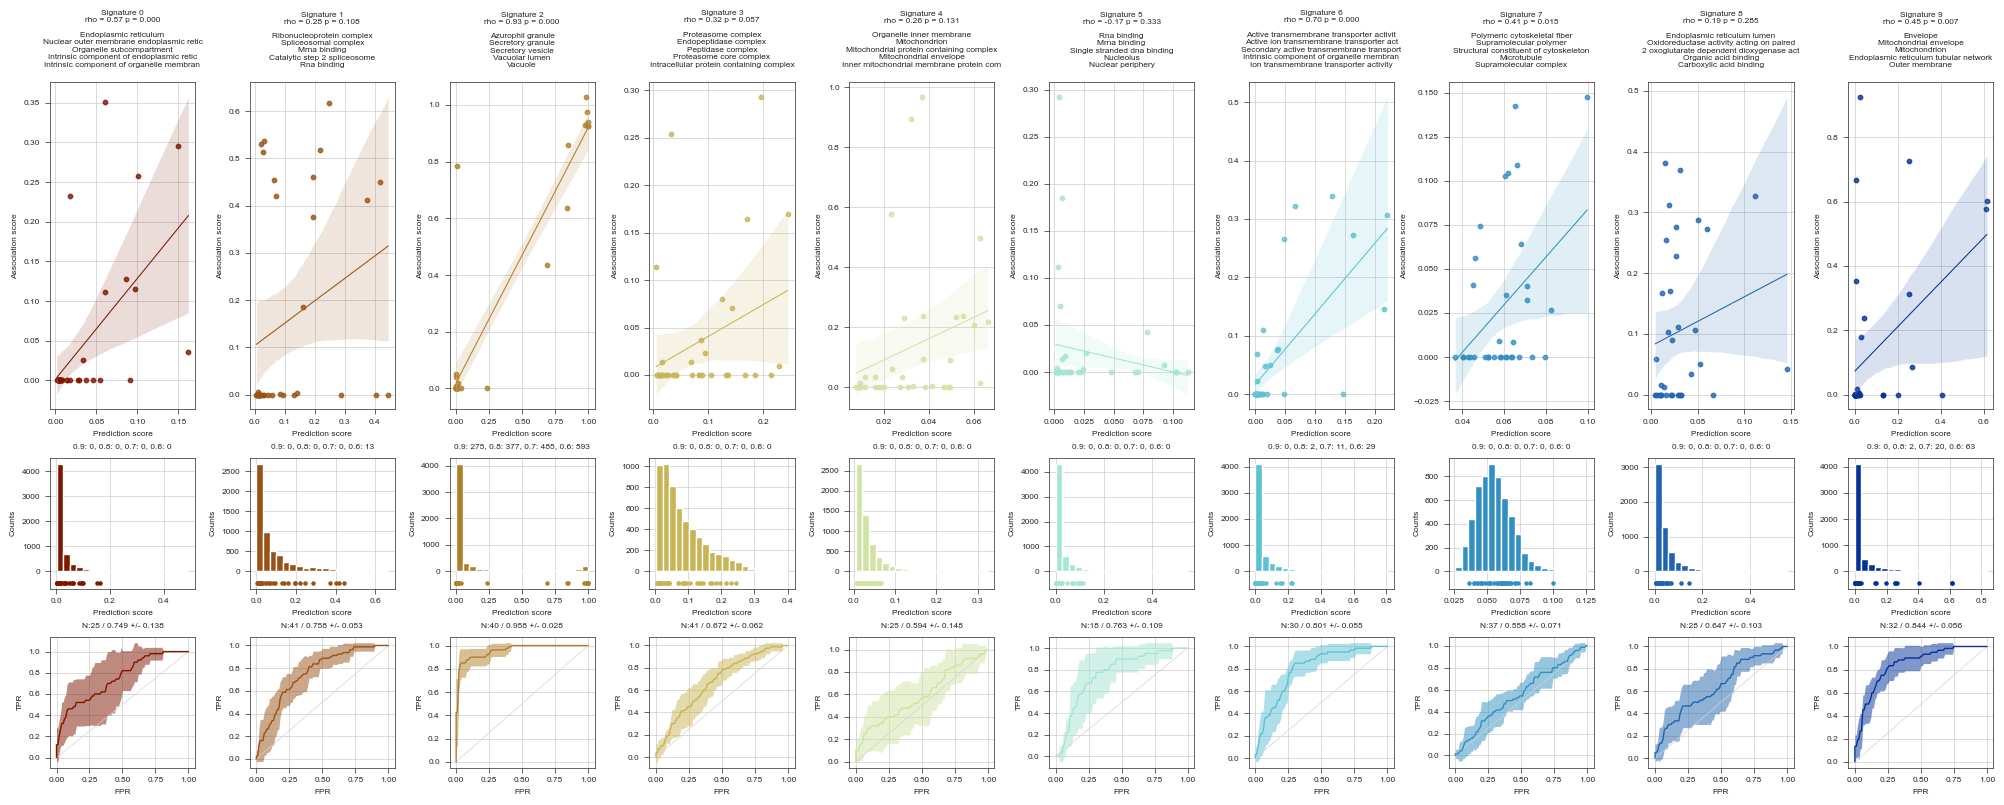

In [27]:
W = data_for_wizard["pipeline"].transform(texts)
R = correlation_plots(W, sufix="filtered")

In [28]:
cemm_pred = [tested_fids]
for r in R:
    cemm_pred += [r[0]]
cemm_ass = [tested_fids]
for r in R:
    cemm_ass += [r[1]]
    
cemm_pred = pd.DataFrame(np.array(cemm_pred).T, columns=["fid"] + ["Sign {0}".format(i) for i in range(10)])
cemm_ass = pd.DataFrame(np.array(cemm_ass).T, columns=["fid"] + ["Sign {0}".format(i) for i in range(10)])

In [92]:
def candidates_per_signature(dfp, dfa, sign_idx):
    col = "Sign {0}".format(sign_idx)
    dfp_ = dfp[["fid", col]].rename(columns={col: "p"})
    dfa_ = dfa[["fid", col]].rename(columns={col: "a"})
    df_ = dfp_.merge(dfa_, on="fid", how="left")
    df_ = df_.sort_values(by="a", ascending=False)
    return df_.head(10)

candidates_per_signature(cemm_pred, cemm_ass, 9)

,fid,p,a
23,V0049,0.025496645,0.9263152629757258
30,V0302,0.25089756,0.725995584555237
7,V0017,0.003800255,0.6663175082785395
21,V0047,0.6134507,0.6014802403409657
24,V0051,0.6111647,0.5781227245904044
28,V0081,0.0043632854,0.35351507703268736
26,V0053,0.25193176,0.3136389075622917
22,V0048,0.040662475,0.23762542828704886
31,V0480,0.027380716,0.17831577106872248
18,V0037,0.26389033,0.08614094314615604


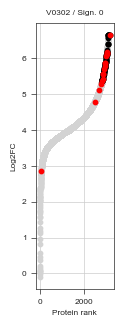

In [85]:
from stylia import NamedColors

pht = pd.read_csv(os.path.join(results_folder, "ProteinHasTopic.csv"))

def individual_validation_plot_from_cemm(ax, fid, signature_idx):
    sign_prots = pht.sort_values(by="Topic {0}".format(signature_idx), ascending=False)["gene_name"].tolist()[:20]
    filt_prots = texts[tested_fids.index(fid)].split(" ")
    df_ = df[df["FragID"] == fid]
    df_ = df_[df_["Abundance_Ratio_PValue"].notnull()]
    R = []
    for r in df_[["Accession", "Abundance_Ratio_log2"]].values:
        R += [[pid2name[r[0]], r[1]]]
    data = pd.DataFrame(R, columns=["gene_name", "log2fc"])
    data = data.sort_values(by="log2fc", ascending=True)
    
    x = [i for i in range(data.shape[0])]
    y = data["log2fc"].tolist()
    
    pid2idx = dict((k,i) for i,k in enumerate(data["gene_name"].tolist()))
    pid2val = dict((r[0], r[1]) for r in data.values)
    
    ax.scatter(x,y, color=NamedColors().gray)
    
    for s in filt_prots:
        if s not in pid2idx:
            continue
        ax.scatter([pid2idx[s]], [pid2val[s]], color="black")
        
    for s in sign_prots:
        if s not in pid2idx:
            continue
        ax.scatter([pid2idx[s]], [pid2val[s]], color="red")
    
    stylia.label(ax, title="{0} / Sign. {1}".format(fid, signature_idx), xlabel="Protein rank", ylabel="Log2FC")

fig, axs = stylia.create_figure(1,1, width=1)

ax = axs.next()
individual_validation_plot_from_cemm(ax, "V0302", 0)

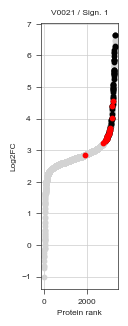

In [86]:
fig, axs = stylia.create_figure(1,1, width=1)

ax = axs.next()
individual_validation_plot_from_cemm(ax, "V0021", 1)

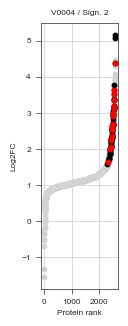

In [87]:
fig, axs = stylia.create_figure(1,1, width=1)

ax = axs.next()
individual_validation_plot_from_cemm(ax, "V0004", 2)

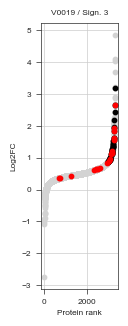

In [88]:
fig, axs = stylia.create_figure(1,1, width=1)

ax = axs.next()
individual_validation_plot_from_cemm(ax, "V0019", 3)

In [ ]:
fig, axs = stylia.create_figure(1,1, width=1)

ax = axs.next()
individual_validation_plot_from_cemm(ax, "V0019", 3)

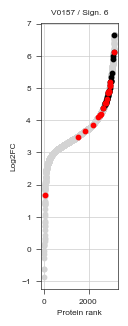

In [96]:
fig, axs = stylia.create_figure(1,1, width=1)

ax = axs.next()
individual_validation_plot_from_cemm(ax, "V0157", 6)

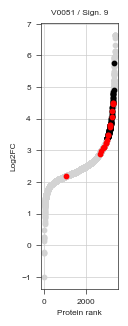

In [94]:
fig, axs = stylia.create_figure(1,1, width=1)

ax = axs.next()
individual_validation_plot_from_cemm(ax, "V0051", 9)

In [5]:
def parker_paper_data():
    file_name = "../data/woo_and_parker_papers/parker_20uM_FFF_vs_cpd1_HEK293T.tsv"
    data = pd.read_csv(file_name, sep="\t")
    columns = list(data.columns)
    compound_columns = [c for c in columns if "_vs_" in c]
    results = {}
    for c in compound_columns:
        df_ = data[["Accession", c]]
        df_ = df_[df_[c].notnull()].rename(columns={c:"Value"})
        k = "PRK{0}".format(c.split("_")[0])
        results[k] = df_.copy().sort_values(by="Value", ascending=False)
    return results

def parker_predictions():
    data = pd.read_csv("../data/woo_and_parker_papers/parker_compounds.tsv", sep="\t")
    smi2id = {}
    for r in data.values:
        smi2id[r[1]] = "PRK{0}".format(r[0])
    data = pd.read_csv("../data/woo_and_parker_papers/predictions-parker.csv")
    sign_columns = [x for x in list(data.columns) if "Sign-" in x]
    my_smiles = [k for k in smi2id.keys()]
    data = data[data["SMILES"].isin(my_smiles)]
    data["fid"] = [smi2id[k] for k in data["SMILES"].tolist()]
    return data[["fid"]+sign_columns]

parker_results = parker_paper_data()
parker_preds = parker_predictions()

In [6]:
parker_preds

,fid,Sign-0,Sign-1,Sign-2,Sign-3,Sign-4,Sign-5,Sign-6,Sign-7,Sign-8,Sign-9
0,PRK2,0.215337,0.031769,0.001230,0.023111,0.023895,0.159960,0.006410,0.037539,0.023787,0.015117
1,PRK3,0.024551,0.533278,0.000157,0.013009,0.046457,0.047148,0.004114,0.059432,0.052274,0.069064
2,PRK4,0.053704,0.281835,0.000283,0.019922,0.052153,0.000786,0.085840,0.048050,0.030732,0.254322
3,PRK6,0.000805,0.112329,0.003370,0.027179,0.014645,0.031423,0.001775,0.062836,0.034227,0.000898
4,PRK7,0.177458,0.456216,0.001133,0.044713,0.063204,0.001214,0.008453,0.057595,0.018299,0.068978
5,PRK8,0.000782,0.058601,0.239772,0.048070,0.008763,0.019201,0.246994,0.037474,0.033445,0.011784
6,PRK9,0.051665,0.049993,0.864203,0.015216,0.008318,0.004833,0.012239,0.047446,0.042709,0.012659
7,PRK11,0.009723,0.008474,0.254491,0.062552,0.008615,0.018698,0.044992,0.043482,0.007583,0.139068
8,PRK12,0.000868,0.007387,0.990250,0.065821,0.013567,0.002934,0.002042,0.075469,0.034589,0.014848
9,PRK13,0.001425,0.015292,0.153929,0.061362,0.009865,0.007852,0.430394,0.039200,0.051421,0.002118


In [2]:
def woo_paper_data():
    results = {}
    for fn in os.listdir("../data/woo_and_parker_papers"):
        if not fn.startswith("woo_10uM"):
            continue
        data = pd.read_csv("../data/woo_and_parker_papers/{0}".format(fn), sep="\t")
        k = list(data["compound"])[0]
        df_ = data[["Master.Protein.Accession", "log2FC"]]
        df_ = df_[df_["log2FC"].notnull()].rename(columns={"Master.Protein.Accession":"Accession", "log2FC": "Value"})
        df_ = df_.sort_values(by="Value", ascending=False)
        results[k] = df_
    return results

def woo_predictions():
    data = pd.read_csv("../data/woo_and_parker_papers/woo_compounds.tsv", sep="\t")
    smi2id = {}
    for r in data.values:
        smi2id[r[1]] = r[0]
    data = pd.read_csv("../data/woo_and_parker_papers/predictions-woo.csv")
    sign_columns = [x for x in list(data.columns) if "Sign-" in x]
    my_smiles = [k for k in smi2id.keys()]
    data = data[data["SMILES"].isin(my_smiles)]
    data["fid"] = [smi2id[k] for k in data["SMILES"].tolist()]
    return data[["fid"]+sign_columns]

woo_results = woo_paper_data()
woo_preds = woo_predictions()

In [7]:
def cemm_prospective_data():
    results = {}
    for fid in tested_fids:
        data = df[df["FragID"] == fid][["Accession", "Abundance_Ratio_log2"]]
        data = data.sort_values(by="Abundance_Ratio_log2", ascending=False)
        data = data.rename(columns={"Abundance_Ratio_log2": "Value"})
        results[fid] = data
    return results

def cemm_prospective_predictions():
    data = dp[dp["FragID"].isin(tested_fids)]
    columns = [x for x in list(data.columns) if x.startswith("signature_")]
    data = data[["FragID"] + columns]
    renamer = dict((k, "Sign-{0}".format(k.split("_")[1])) for k in columns)
    data = data.rename(columns=renamer)
    data = data.rename(columns={"FragID":"fid"}).reset_index(drop=True)
    return data

cemm_results = cemm_prospective_data()
cemm_preds = cemm_prospective_predictions()
        

In [8]:
results_external = dict((k,v) for d in [woo_results, parker_results, cemm_results] for k,v in d.items())
preds_external = pd.concat([woo_preds, parker_preds, cemm_preds], axis=0).reset_index(drop=True)

In [9]:
fids_external = sorted(preds_external["fid"].tolist())

In [10]:
chemical_space_prediction = pd.read_csv("../../fragment-predictor/data/predictions.csv")

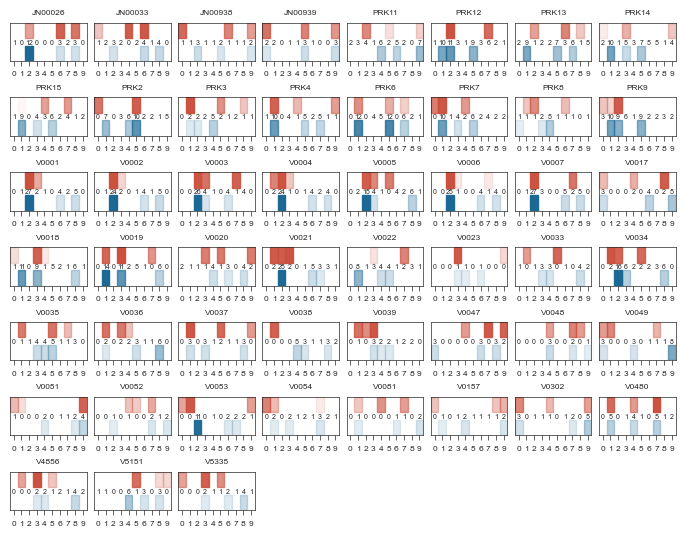

In [29]:
from scipy.stats import fisher_exact, percentileofscore
from matplotlib.patches import Rectangle
from stylia import NamedColors

def evaluate_external_fid_sign(fid_ext, sign_idx, percentile):
    all_scores = chemical_space_prediction["signature_{0}".format(sign_idx)].tolist()
    sign_proteins = pht.sort_values(by="Topic {0}".format(sign_idx), ascending=False)["gene_name"].tolist()[:30]
    op = results_external[fid_ext]
    op = op.sort_values(by="Value", ascending=False)["Accession"].tolist()[:150]
    obs_proteins = []
    for p in op:
        if p in pid2name:
            obs_proteins += [pid2name[p]]
        else:
            obs_proteins += [p]
    universe = set(pht["gene_name"])
    obs_proteins = universe.intersection(obs_proteins)
    a = len(set(obs_proteins).intersection(sign_proteins))
    b = len(set(obs_proteins)) - a
    c = len(set(sign_proteins)) - a
    d = len(universe) - (a+b+c)
    odds, pvalue = fisher_exact([[a,b],[c,d]], alternative="greater")
    score = list(preds_external[preds_external["fid"] == fid_ext]["Sign-{0}".format(sign_idx)])[0]
    if percentile:
        score = percentileofscore(all_scores, score)/100
    return odds, pvalue, a, score 


def evaluation_plot(ax, fid):
    scores = []
    pvalues = []
    odds = []
    tps = []
    
    def score_scaler(x):
        val = (x - 0.7)/(1-0.7)
        return np.clip([val], 0, 1)[0]
    
    def pvalue_scaler(x):
        val = (x - np.log10(0.1))/(10-np.log10(0.1))
        return np.clip([val], 0, 1)[0]
    
    for i in range(10):
        odd, pvalue, a, score = evaluate_external_fid_sign(fid, i, percentile=True)
        scores += [(i, score)]
        pvalues += [(i, -np.log10(pvalue))]
        odds += [(i, odd)]
        tps += [(i, a)]
    scores = sorted(scores, key=lambda x: -x[1])
    pvalues = sorted(pvalues, key=lambda x: -x[1])
    odds = sorted(pvalues, key=lambda x: -x[1])
    for x_ in scores[:3]:
        r = Rectangle((x_[0]-0.5, 1.2), 1, 0.8, color=NamedColors().red, alpha=score_scaler(x_[1]))
        ax.add_patch(r)
    for x_ in pvalues[:3]:
        r = Rectangle((x_[0]-0.5, 0), 1, 0.8, color=NamedColors().blue, alpha=pvalue_scaler(x_[1]))
        ax.add_patch(r)
    for tp in tps:
        ax.text(tp[0], 1, tp[1], va="center", ha="center")
    ax.set_xticks([i for i in range(10)])
    ax.set_yticks([])
    ax.set_yticklabels("")
    ax.grid()
    
    ax.set_xlim(-0.5, 9.5)
    ax.set_ylim(0, 2)
    
    stylia.label(ax, title=fid, ylabel="", xlabel = "")

    
fig, axs = stylia.create_figure(7, 8, width=stylia.TWO_COLUMNS_WIDTH*0.96, height=stylia.TWO_COLUMNS_WIDTH*0.75)
    
for i in range(7*8):
    ax = axs.next()
    if i < len(fids_external):
        ext_fid = fids_external[i]
        evaluation_plot(ax, ext_fid)
    else:
        ax.set_axis_off()
        stylia.label(ax, title="", xlabel="", ylabel="")

plt.tight_layout()
stylia.save_figure(os.path.join(output_folder, "exploratory_validations.png"))
stylia.save_figure(os.path.join(output_folder, "exploratory_validations.pdf"))

In [13]:
def evaluation_counter(fid, overlook_signature_2=False):
    scores = []
    pvalues = []
    odds = []
    tps = []
    
    def score_scaler(x):
        val = (x - 0.7)/(1-0.7)
        return np.clip([val], 0, 1)[0]
    
    def pvalue_scaler(x):
        val = (x - np.log10(0.1))/(10-np.log10(0.1))
        return np.clip([val], 0, 1)[0]
    
    for i in range(10):
        odd, pvalue, a, score = evaluate_external_fid_sign(fid, i, percentile=True)
        scores += [(i, score)]
        pvalues += [(i, -np.log10(pvalue))]
        odds += [(i, odd)]
        tps += [(i, a)]
    scores = sorted(scores, key=lambda x: -x[1])
    pvalues = sorted(pvalues, key=lambda x: -x[1])
    if overlook_signature_2:
        for x in pvalues[:3]:
            if x[0] == 2:
                return 
    odds = sorted(pvalues, key=lambda x: -x[1])
    match_score = 0
    ds = {}
    for i,v in enumerate(scores[:3]):
        ds[v[0]] = 3-i
    dp = {}
    for i,v in enumerate(pvalues[:3]):
        dp[v[0]] = 3-i
    ks = [x for x in ds.keys()]
    kp = [x for x in dp.keys()]
    common = set(ks).intersection(kp)
    for c in common:
        match_score += np.mean([ds[c], dp[c]])
    return match_score


def random_counter():
    match_score = 0
    idxs = [i for i in range(10)]
    rnd_s = random.sample(idxs, 3)
    rnd_p = random.sample(idxs, 3)
    ds = {}
    for i,v in enumerate(rnd_s):
        ds[v] = 3-i
    dp = {}
    for i,v in enumerate(rnd_p):
        dp[v] = 3-i
    ks = [x for x in ds.keys()]
    kp = [x for x in dp.keys()]
    common = set(ks).intersection(kp)
    for c in common:
        match_score += np.mean([ds[c], dp[c]])
    return match_score

In [15]:
from tqdm import tqdm
import random

def significance_evaluation(overlook_signature_2):
    total_match_scores = []
    for fid in fids_external:
        s = evaluation_counter(fid, overlook_signature_2=overlook_signature_2)
        if s is None:
            continue
        total_match_scores += [s]

    total_match_score = np.sum(total_match_scores)
    rnd_match_scores = []
    for _ in tqdm(range(100000)):
        rnd_match_score = 0
        for _ in total_match_scores:
            rnd_match_score += random_counter()
        rnd_match_scores += [rnd_match_score]
    return total_match_score, rnd_match_scores

ms, rms = significance_evaluation(False)
ms2, rms2 = significance_evaluation(True)

100%|█████████████████████████████████| 100000/100000 [00:20<00:00, 4977.13it/s]


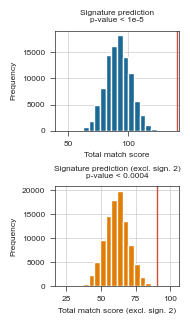

In [21]:
fig, axs = stylia.create_figure(2,1, width=stylia.TWO_COLUMNS_WIDTH*0.26, height=stylia.TWO_COLUMNS_WIDTH*0.45)
ax = axs.next()
ax.hist(rms, 20, color=NamedColors().blue)
p = np.sum(rms > ms)/len(rms)
ax.axvline(ms, lw=1, color=NamedColors().red)
stylia.label(ax, title="Signature prediction\np-value < 1e-5", xlabel="Total match score", ylabel="Frequency")
ax = axs.next()
rms2 = np.array(rms2)
p2 = np.sum(rms2 > ms2)/len(rms2)
ax.hist(rms2, 20, color=NamedColors().orange)
ax.axvline(ms2, lw=1, color=NamedColors().red)
stylia.label(ax, title="Signature prediction (excl. sign. 2)\np-value < {0:.4f}".format(p2), xlabel="Total match score (excl. sign. 2)", ylabel="Frequency")
plt.tight_layout()
stylia.save_figure(os.path.join(output_folder, "match_scores_evaluation.png"))
stylia.save_figure(os.path.join(output_folder, "match_scores_evaluation.pdf"))

In [662]:
def observed_common_genes(fid_ext, sign_idx):
    all_scores = chemical_space_prediction["signature_{0}".format(sign_idx)].tolist()
    sign_proteins = pht.sort_values(by="Topic {0}".format(sign_idx), ascending=False)["gene_name"].tolist()[:30]
    op = results_external[fid_ext]
    op = op.sort_values(by="Value", ascending=False)["Accession"].tolist()[:150]
    obs_proteins = []
    for p in op:
        if p in pid2name:
            obs_proteins += [pid2name[p]]
        else:
            obs_proteins += [p]
    universe = set(pht["gene_name"])
    obs_proteins = universe.intersection(obs_proteins)
    results = {
        "obs_proteins": set(obs_proteins),
        "sign_proteins": set(sign_proteins),
        "common_proteins": set(obs_proteins).intersection(sign_proteins),
        "obs_proteins_sorted": obs_proteins
    }
    return results

def external_validation_plot_focus_genes(ax, fid, sign_idx):
    color = topic_colors[sign_idx]
    res = observed_common_genes(fid, sign_idx)
    the_genes = []
    for i, gn in enumerate(res["obs_proteins_sorted"]):
        if gn in res["common_proteins"]:
            ax.plot([0, 1], [i,i], color=color, lw=1)
            the_genes += [(gn, i)]
    ax.set_ylim(len(res["obs_proteins_sorted"]), -1)
    ax.set_xlim(0, 6)
    the_genes = the_genes[:5]
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()
    ax.set_yticks(np.arange(0, ylim[0], 10))
    pos = np.linspace(ylim[1], ylim[0], len(the_genes)+2)[1:-1]
    for i, r in enumerate(the_genes[:5]):
        ax.text(xlim[1]*0.95, pos[i], r[0], ha="right", va="center")
        ax.plot([1.5, 1], [pos[i], r[1]], color=color, lw=0.5)
        ax.plot([1.5, 1.8], [pos[i], pos[i]], color=color, lw=0.5)
    ax.grid()
    ax.set_xticks([])
    color = NamedColors().gray
    ax.set_facecolor((color[0], color[1], color[2],0.25))
    stylia.label(ax, title=fid+" Sign. {0}".format(sign_idx), ylabel="", xlabel="")

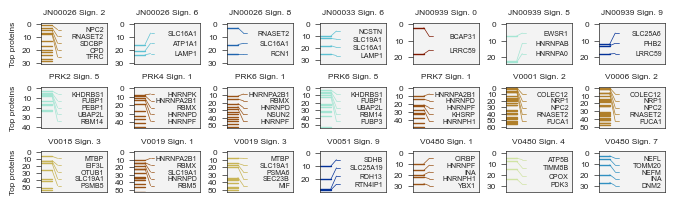

In [665]:
examples_to_show = [
    ("V0001", 2),
    ("PRK7", 1),
    ("V0019", 1),
    ("V0019", 3),
    ("JN00033", 6),
    ("JN00026", 2),
    ("JN00026", 6),
    ("JN00026", 8),
    ("V0480", 7),
    ("V0018", 3),
    ("JN00939", 0),
    ("JN00939", 5),
    ("JN00939", 9),
    ("PRK2", 5),
    ("PRK4", 1),
    ("PRK6", 1),
    ("PRK6", 5),
    ("V0051", 9),
    ("V0480", 1),
    ("V0480", 4),
    ("V0480", 7),
    ("V0006", 2)
]
examples_to_show = sorted(set(examples_to_show))

fig, axs = stylia.create_figure(3,7, width=stylia.TWO_COLUMNS_WIDTH*0.945, height=stylia.TWO_COLUMNS_WIDTH*0.28)
for i, ex in enumerate(examples_to_show):
    ax = axs.next()
    external_validation_plot_focus_genes(ax, ex[0], ex[1])
    if i in [0, 7, 14]:
        ax.set_ylabel("Top proteins")
plt.tight_layout()

stylia.save_figure(os.path.join(output_folder, "external_validations.png"))
stylia.save_figure(os.path.join(output_folder, "external_validations.pdf"))